In [1]:
import os
import json
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [3]:
 # Целевой признак - число рекомендаций (лайков) статьи, 
    # приведенные в статье значения - логарифм с единицей
    # от числа рекомендаций
path_to_train = '/home/misha/environments/my_env/MyProjects/HowGoodIsYourArticle/train.json'
path_to_data = '/home/misha/environments/my_env/MyProjects/HowGoodIsYourArticle/'


In [4]:
!ls -l $path_to_data

итого 4145416
-rw-rw-r-- 1 misha misha     874228 дек 11 21:52 first_ridge3.csv
-rw-rw-r-- 1 misha misha     870760 дек 11 18:07 first_ridge4.csv
-rw-rw-r-- 1 misha misha     870760 дек 11 18:07 first_ridge.csv
-rw-rw-r-- 1 misha misha     526712 дек 10 23:40 MediumArticle_baseline_ubuntu.ipynb
-rw-rw-r-- 1 misha misha     848234 дек 11 18:31 MediumArticle_Ridge_baseline_tf-idf_ubuntu.ipynb
-rw-rw-r-- 1 misha misha     735235 дек 11 21:52 MediumArticle_Ridge_baseline_ubuntu.ipynb
-rw-rw-r-- 1 misha misha     884217 ноя 29  2019 sample_submission.csv
-rw-rw-r-- 1 misha misha 1156020029 ноя 29  2019 test.json
-rw-rw-r-- 1 misha misha     555138 ноя 29  2019 test_log1p_recommends.csv
-rw-rw-r-- 1 misha misha  347316113 дек 11 15:37 test_raw_content.txt
-rw-rw-r-- 1 misha misha 2086185062 ноя 29  2019 train.json
-rw-rw-r-- 1 misha misha     912544 ноя 29  2019 train_log1p_recommends.csv
-rw-rw-r-- 1 misha misha  648268208 дек 11 15:37 train_raw_content.txt


#### Функция для чтения JSON файла (без сбоев при исп. escape-символов)

In [5]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result



#### Функция, берущая json файл, убирающая html-теги, и оставляющая только текст статьи

In [6]:
def preprocess(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            output_list.append(content_no_html_tags)
    return output_list



In [7]:
%%time
train_raw_content = preprocess(path_to_inp_json_file=\
                               os.path.join(path_to_data, 
                                                'train.json'))


<ipython-input-6-2e360253a763>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(inp_file):



CPU times: user 3min 9s, sys: 2.08 s, total: 3min 12s
Wall time: 3min 11s


In [8]:
%%time
test_raw_content = preprocess(path_to_inp_json_file=\
                              os.path.join(path_to_data, 'test.json'))



<ipython-input-6-2e360253a763>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(inp_file):



CPU times: user 1min 44s, sys: 1.5 s, total: 1min 46s
Wall time: 1min 46s


In [9]:
!head $path_to_data'train_raw_content.txt'

MediumEveryone’s stories and ideasAug 13, 2012Medium Terms of ServiceEffective: March 7, 2016These Terms of Service (“Terms”) are a contract between you and A Medium Corporation. They govern your use of Medium’s sites, services, mobile apps, products, and content (“Services”).By using Medium, you agree to these Terms. If you don’t agree to any of the Terms, you can’t use Medium.We can change these Terms at any time. We keep a historical record of all changes to our Terms on GitHub. If a change is material, we’ll let you know before they take effect. By using Medium on or after that effective date, you agree to the new Terms. If you don’t agree to them, you should delete your account before they take effect, otherwise your use of the site and content will be subject to the new Terms.Content rights & responsibilitiesYou own the rights to the content you create and post on Medium.By posting content to Medium, you give us a nonexclusive license to publish it on Medium Services, including a

#### Конвертируем набор текста в матрицу признаков

In [10]:
# Конвертируем набор текста в матрицу токенов
# Ограничим число признаков 100000
cv = TfidfVectorizer(max_features=50000)

In [11]:
%%time
# подаем на вход ему файлы train\test_raw_content.txt
X_train = cv.fit_transform(train_raw_content)
X_test = cv.transform(test_raw_content)

CPU times: user 1min 42s, sys: 1.31 s, total: 1min 43s
Wall time: 1min 44s


In [12]:
X_train.shape, X_test.shape

((62313, 50000), (34645, 50000))

#### Считываем метки (кол-во рекомендаций)

In [13]:
y_train = pd.read_csv(os.path.join(path_to_data, 'train_log1p_recommends.csv'), index_col='id')
#y_test = pd.read_csv(os.path.join(path_to_data, 'test_log1p_recommends.csv'), index_col='id')
y_train = y_train['log_recommends'].values
#y_test = y_test['log_recommends'].values

#### Построим распределение целевой переменной

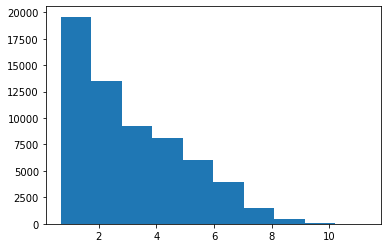

In [14]:
plt.hist(y_train);

In [15]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, train_size=0.7)

#### Обучим Ridge-регрессию на данных

In [16]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(random_state=17)

In [17]:
X_tr.shape, y_tr.shape

((43619, 50000), (43619,))

In [18]:
%%time 
ridge_model.fit(X_tr, y_tr)

CPU times: user 22.7 s, sys: 48.2 s, total: 1min 10s
Wall time: 10.8 s


Ridge(random_state=17)

In [19]:
ridge_07test_pred = ridge_model.predict(X_te)

In [20]:
ridge_07test_pred

array([2.45488397, 2.32567696, 4.68452462, ..., 2.63177281, 3.57353075,
       2.63513942])

In [21]:
mean_absolute_error(y_te, ridge_07test_pred)

1.2008590655404492

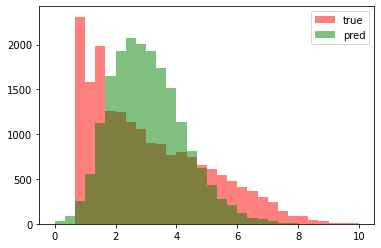

In [22]:
plt.hist(y_te, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_07test_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();



#### Обучаемся и делаем прогноз на тестовой выборке

In [23]:
%%time
ridge_model.fit(X_train, y_train)
ridge_test_pred = ridge_model.predict(X_test)

CPU times: user 34.4 s, sys: 1min 13s, total: 1min 48s
Wall time: 14.5 s


In [24]:
print([i for i in ridge_test_pred])

[3.3935453861165277, 3.547299042090584, 4.132531977583021, 2.2079501393095646, 5.096119908333558, 6.557580861847762, 0.7038532155144341, 2.6623120815123484, 3.1654895219187464, 6.128968722490946, 3.620586870824451, 4.237403177906812, 2.2428578386996634, 2.3913133121972816, 2.6058317453638775, 6.7051374372409684, 5.157615641390805, 6.068419881373652, 5.596464254676109, 3.2774894445880056, 5.4120837401908, 4.854862731135789, 7.178653652473518, 5.559251644698375, 3.4412679805997826, 3.505731614307547, 4.221304910140973, 3.115739157010772, 4.023486685849923, 3.070221686833505, 4.945578155765533, 3.817814548820383, 6.569892538011569, 2.0240276819874725, 3.75373402104292, 3.998678437445507, 6.6082286666280385, 6.950550305201478, 6.388461615504051, 4.72047419778939, 4.871589822334929, 2.2669511549974786, 3.607196094102333, 3.471505078527544, 4.267926467660814, 4.830369557195832, 2.519971820292868, 4.624749315455789, 4.356849003774291, 2.0747810381490672, 2.4466878599810857, 2.590625666535458,

In [25]:
def write_submission(pred, filename, path_to_sample=os.path.join(path_to_data, 'sample_submission.csv')):
    sub = pd.read_csv(path_to_sample, index_col='id')
    sub['log_recommends'] = pred
    sub.to_csv(filename)

In [26]:
write_submission(ridge_test_pred, os.path.join(path_to_data, 'first_ridge4.csv'))

#### Предыдущий итоговый результат Kaggle (с CountVectorizer) :

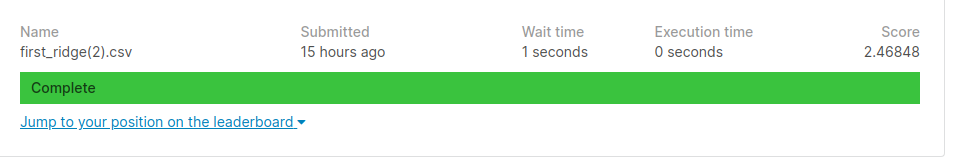

#### Текущий итоговый результат Kaggle (с использованием TF-IDF меры) :

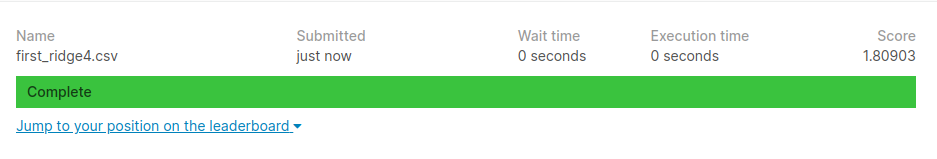
